## Air Quality Prediction from Low-Cost IoT devices
Data Scientist: Victor Kelechi Ahaji

`Objective:`
Developing a machine learning model that accurately predicts CO2 levels using data from Chemotronix’s low-cost sensors. Building this model will help bridge the gap between affordability and precision in carbon emission tracking enabling widespread adoption of low-cost monitoring technologies.

`Expected Result:`
> 1.) Democratize access to environmental monitoring tools.

> 2.) Assist governments and organizations in implementing data-driven policies to curb carbon emissions.

> 3.) Promote sustainability by making emission tracking affordable for communities and industries worldwide.

`Evaluation:`
The evaluation metric for this competition is Root Mean Squared Error.

In [ ]:
!pip install scikit-learn==1.2.0

### Importing Libraries

In [ ]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder, StandardScaler, FunctionTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import mean_squared_error
from scipy.stats import skew

### Loading dataset

In [ ]:
# Load data
train = pd.read_csv("Train.csv")
test = pd.read_csv("test.csv")
sample_submission = pd.read_csv("SampleSubmission.csv")

### Quick Look
Taking an initial look on the dataset to understand structure.

In [ ]:
train.head(3)

,ID,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,device_name,CO2
0,ID_000001,28.975,74.475,2480.0,3476.5,1572.0,1997.0,alpha,585.75
1,ID_000002,31.900,66.500,3813.0,2726.0,4145.0,3180.0,alpha,613.00
2,ID_000003,31.675,60.015,2811.0,1563.5,4250.0,2708.5,alpha,616.50


In [ ]:
# Descriptive statistic of the train dataset
train.describe()

,Temperature,Humidity,MQ7_analog,MQ9_analog,MG811_analog,MQ135_analog,CO2
count,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000,7307.000000
mean,29.681726,69.593742,4230.820902,3976.708841,3995.126568,3444.788240,611.634608
std,2.016785,7.248136,1085.008100,1603.972744,1098.740604,893.426679,16.540953
min,23.440000,52.200000,2380.000000,1098.500000,1353.500000,1186.500000,573.166667
25%,28.490000,65.665000,3362.500000,2832.500000,3181.000000,2912.500000,600.000000
50%,29.290000,70.555000,4061.000000,4073.000000,4137.000000,3586.500000,608.000000
75%,31.717500,74.350000,4780.750000,5286.166667,4731.000000,4143.750000,621.000000
max,33.850000,93.525000,9545.500000,10379.500000,7919.000000,6257.000000,677.000000


From the above, we can understand that we have about 7307 samples in our train dataset.

### Exploratory Data Analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7307 entries, 0 to 7306
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ID            7307 non-null   object 
 1   Temperature   7307 non-null   float64
 2   Humidity      7307 non-null   float64
 3   MQ7_analog    7307 non-null   float64
 4   MQ9_analog    7307 non-null   float64
 5   MG811_analog  7307 non-null   float64
 6   MQ135_analog  7307 non-null   float64
 7   device_name   7307 non-null   object 
 8   CO2           7307 non-null   float64
dtypes: float64(7), object(2)
memory usage: 513.9+ KB


In [ ]:
train.set_index("ID", inplace = True)

From the above we can observe the absence of null values in the features. But for one of the columns; the `device_name` feature might not be represented in the right data type

In [ ]:
print(train["device_name"].nunique())
print(train["device_name"].unique())

3
['alpha' 'beta' 'charlie']


The `device_name` feature should be more of a category data type instead of object.

In [ ]:
# Change the data type from `object` to `category` data type
train["device_name"] = train["device_name"].astype("category")

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7307 entries, ID_000001 to ID_007307
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype   
---  ------        --------------  -----   
 0   Temperature   7307 non-null   float64 
 1   Humidity      7307 non-null   float64 
 2   MQ7_analog    7307 non-null   float64 
 3   MQ9_analog    7307 non-null   float64 
 4   MG811_analog  7307 non-null   float64 
 5   MQ135_analog  7307 non-null   float64 
 6   device_name   7307 non-null   category
 7   CO2           7307 non-null   float64 
dtypes: category(1), float64(7)
memory usage: 464.0+ KB


### Understanding the distribution of train dataset

In [ ]:
# Utilizing skew module of the scipy library
skewness_value = skew(train.select_dtypes(include=["number"]))
Skewness = list(zip(train.select_dtypes(include = ["number"]).columns, skewness_value))
for col, skewness_value in Skewness:
    print(f'Skewness of {col} : {skewness_value:.2f}')

In [ ]:
# Visualizing to understand skewness
# Set plot style
sns.set_style("whitegrid")

# create histograms for each numeric column
fig, ax = plt.subplots(nrows= 3, ncols= 3, figsize =(15,10))
ax = ax.flatten()

for i, col in enumerate(train.select_dtypes(include=["number"]).columns):
    sns.histplot(train[col], bins = 10, kde = True, ax = ax[i], color = 'blue')
    ax[i].set_title(f'Histogram of {col}')
    ax[i].set_xlabel(col)
    ax[i].set_ylabel("Frequency")

plt.tight_layout();

> Based on the above plot and skewness values, we can comment that the dataset is quite normally distributed.

### Understanding the nature of relationship between features.
This is to help avoid multicollinearity.

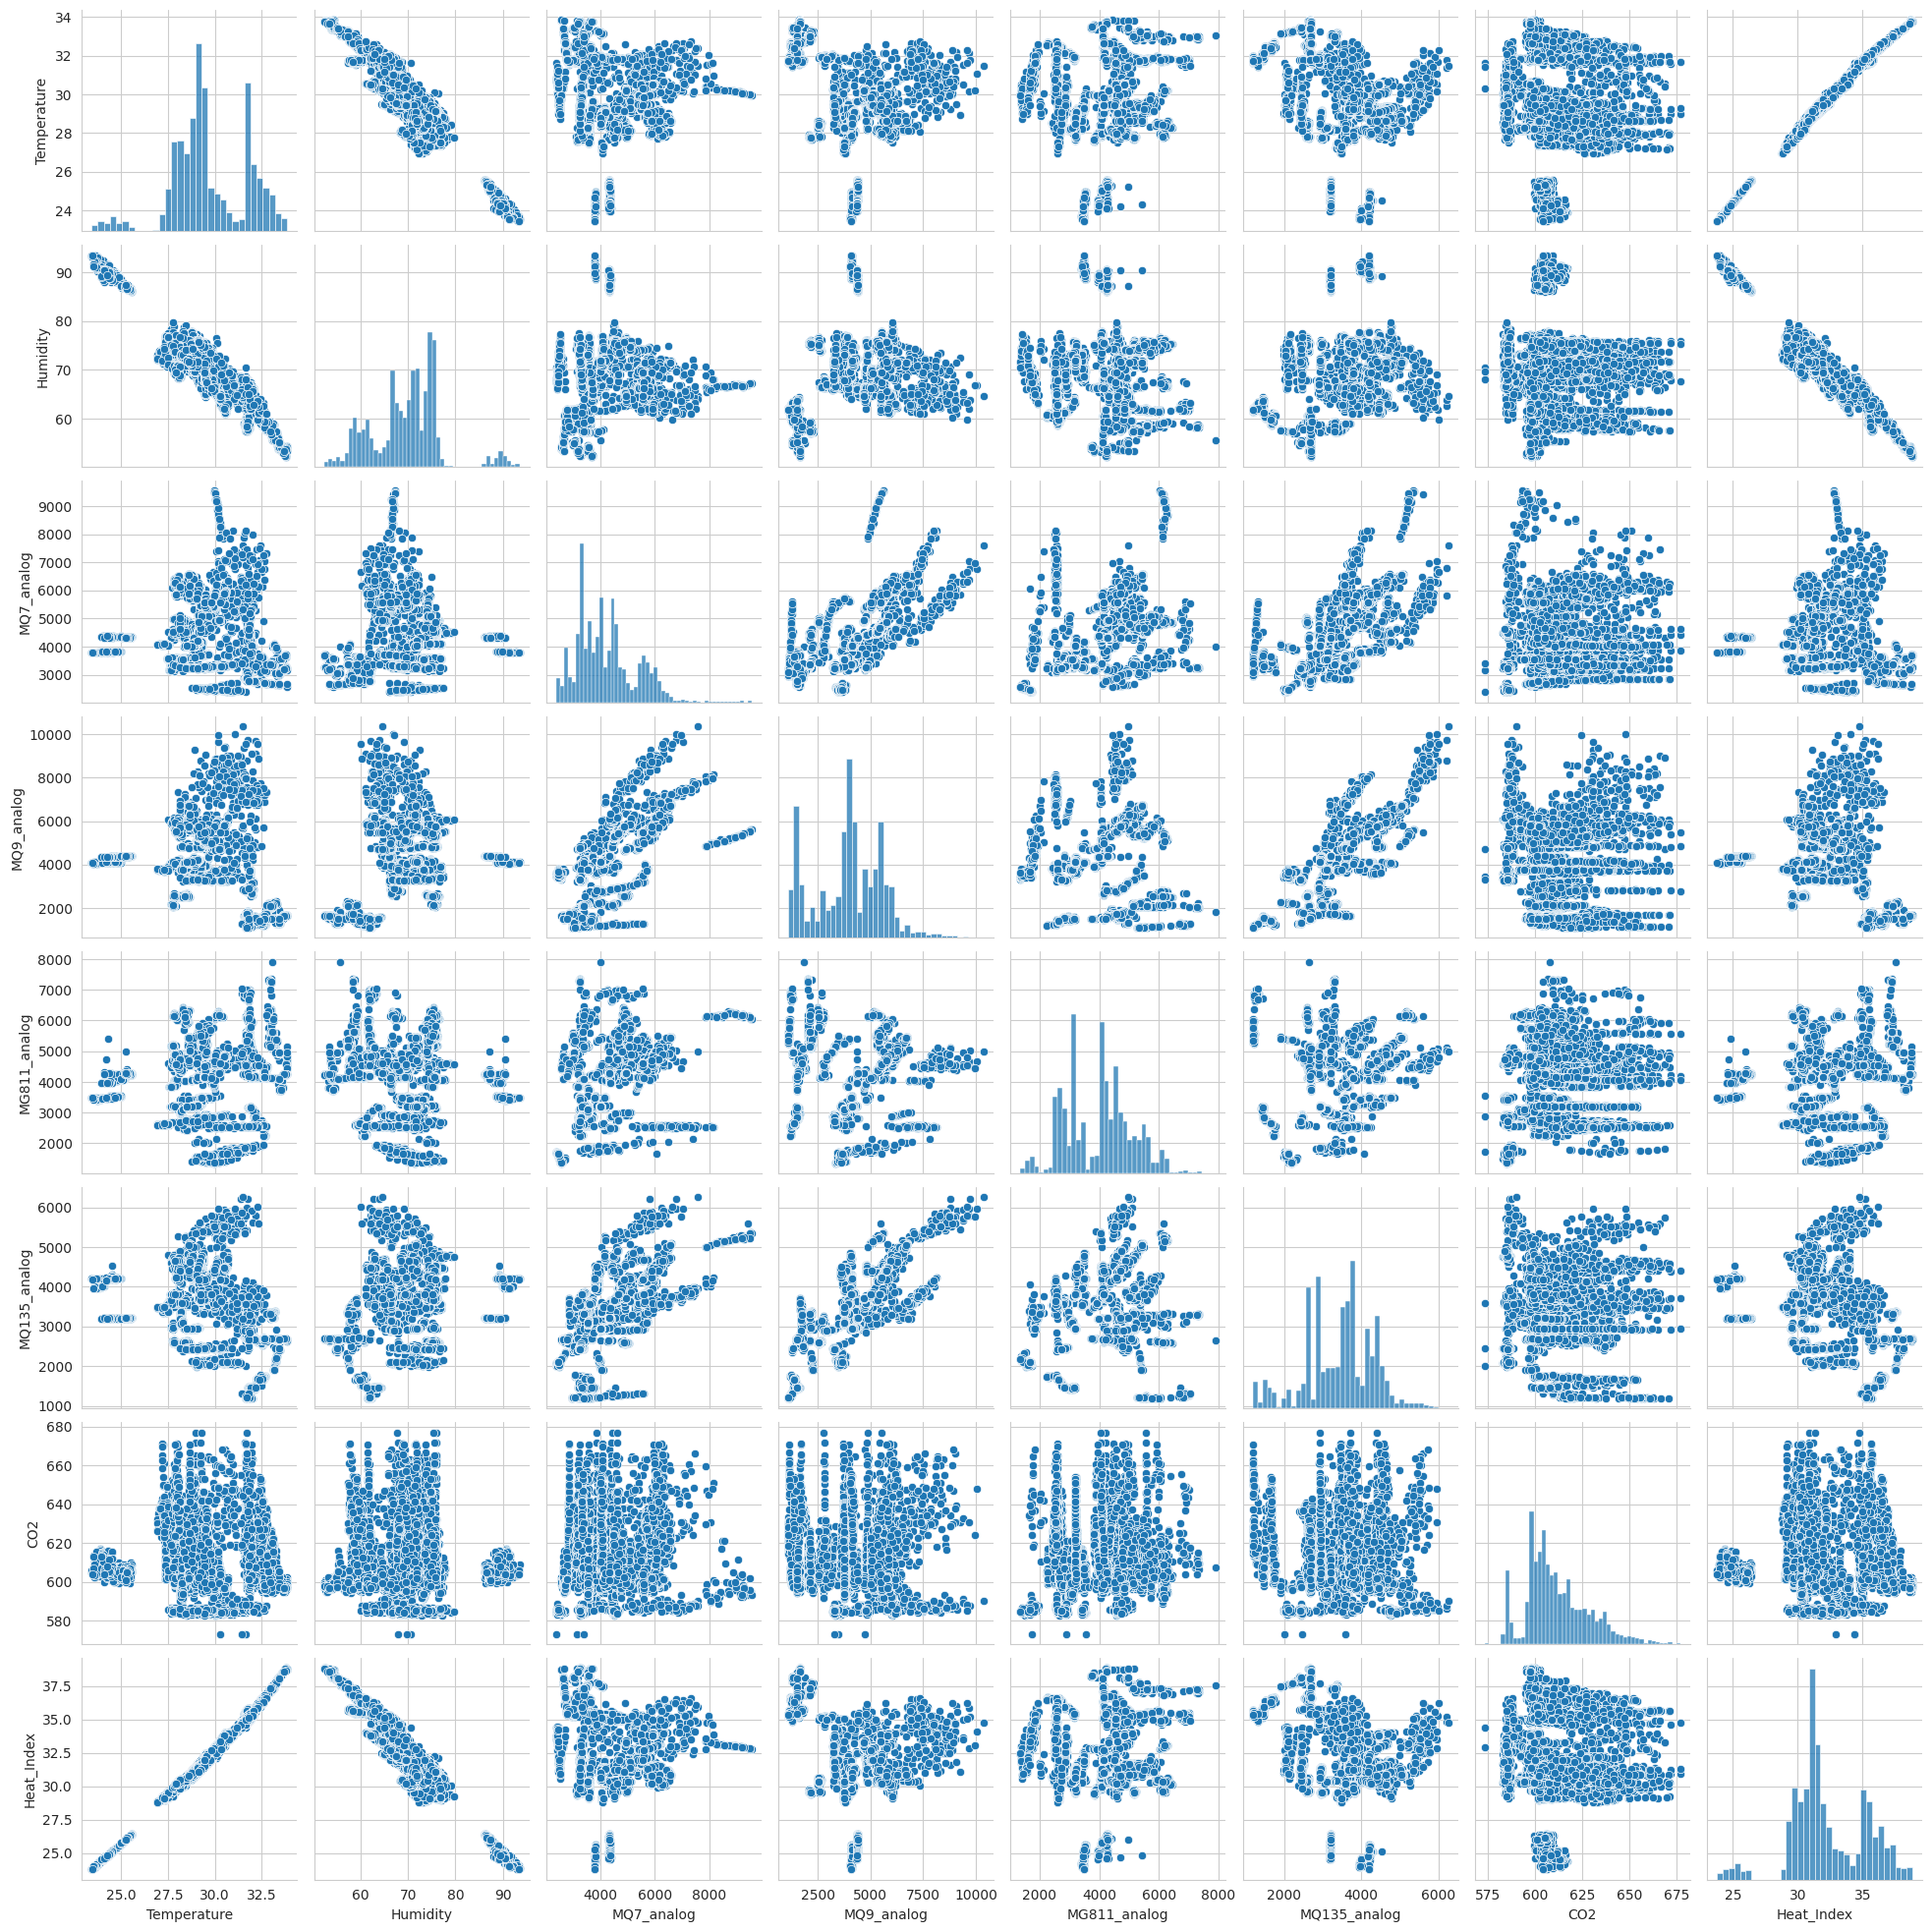

In [ ]:
# Using seabon pairplot
sns.pairplot(train);

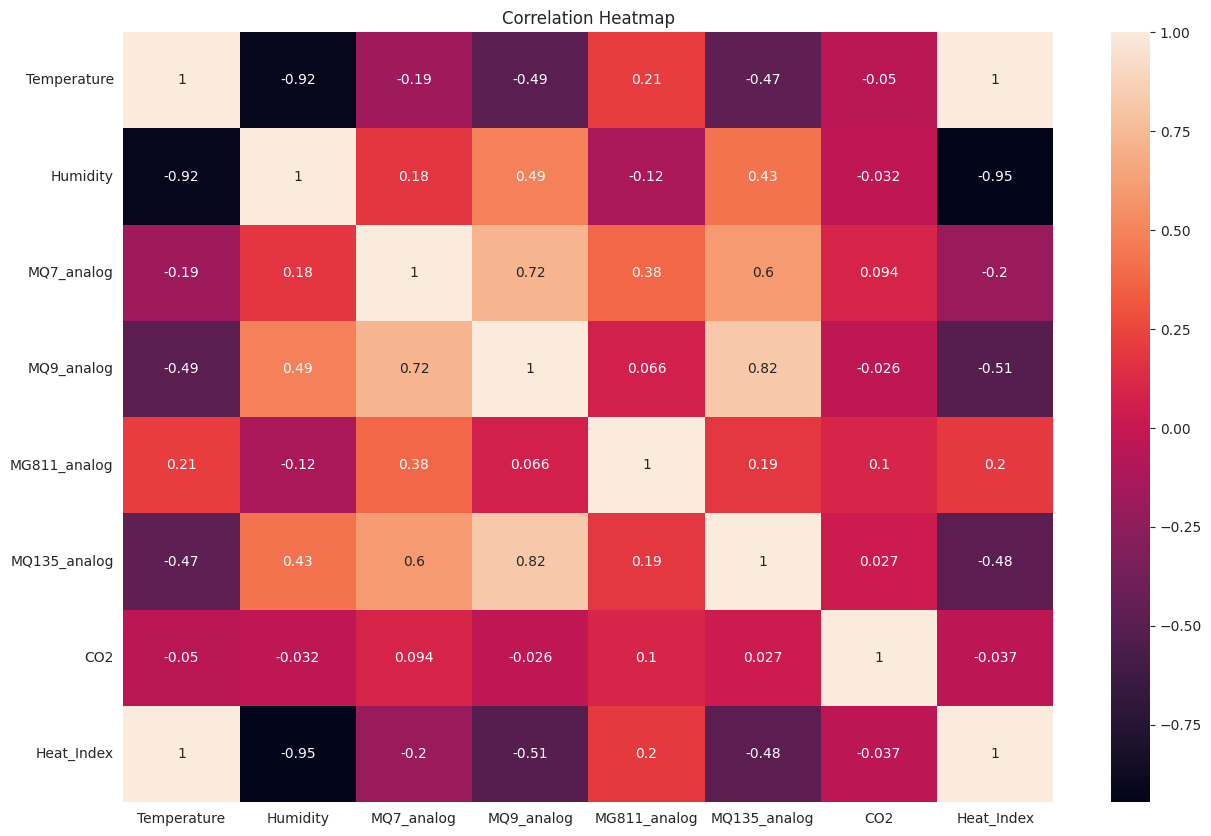

In [ ]:
# Using heatmap to understand correlation
plt.figure(figsize = (15,10))
sns.heatmap(train.drop("device_name", axis = 1).corr(), annot = True)
plt.title("Correlation Heatmap")
plt.show()

### Feature Engineering, Selection and Preprocessing
Based on the above, we have instances of multicollinearity this requires us to drop certain features before model building, but we will not drop these features. An algorithm that penalizes multicollineraity will be utilized.

In [ ]:
# Feature Engineering
# Create Heat Index Feature
train["Heat_Index"] = train["Temperature"] + (0.55 - 0.0055 * train["Humidity"]) * (train["Temperature"] - 14.5)

In [ ]:
# Feature selection and preprocessing
features = train.drop("CO2", axis = 1).columns
target =  'CO2'

In [ ]:
X = train[features]
y = train[target]

In [ ]:
# Feature transformation
numerical_cols = X.select_dtypes(include=["number"]).columns
categorical_col = X.columns.drop(numerical_cols)

# Log Transformation (for positive skewness)
log_transformer = FunctionTransformer(lambda x: np.log1p(x), validate=False)

# Squared Transformation (for negative skewness)
squared_transformer = FunctionTransformer(lambda x: x**2, validate=False)

# Standardization
scaler = StandardScaler()

# One-Hot Encoding for Categorical features
encoder = OneHotEncoder(handle_unknown='ignore')

# PCA for dimensionality reduction
pca = PCA(n_components = 6)

# Column Transfprmer to apply transformation
preprocessor = ColumnTransformer([
    ("log", log_transformer, ["MG811_analog", "MQ9_analog","Humidity","MQ7_analog"]),  # Apply log transformation to positively skewed features
    ("square", squared_transformer, ["MQ135_analog","Temperature"]),  # Apply squared transformation to negatively skewed features
    ("scale", scaler, numerical_cols),  # Standardization for all numeric features
    ("one_hot", encoder, categorical_col),  # One-Hot Encoding
])

# Create a Pipeline
pipeline = Pipeline([
    ("preprocessor", preprocessor),
    ("pca", pca)
])

# Apply Transformations
X_processed = pipeline.fit_transform(X)

# Convert to DataFrame for easy viewing
X_processed = pd.DataFrame(X_processed, index = train.index)
X_processed


,0,1,2,3,4,5
0,-8.676659e+06,-122.203220,-1.318465,1.046088,-0.528408,0.413072
1,-2.552268e+06,109.995541,-0.225301,-0.253537,-0.204873,0.501607
2,-5.328696e+06,71.168191,-0.546740,-0.977934,0.202873,-0.503762
3,-5.249939e+06,65.856064,-0.490656,-1.002081,0.288472,-0.604403
4,-1.117871e+07,20.429335,1.207787,-1.311700,0.207232,-0.067704
...,...,...,...,...,...,...
7302,4.891432e+06,75.338898,0.803429,0.699903,0.120286,-0.554015
7303,6.814314e+06,-32.154174,1.256732,0.397812,0.783636,-0.647401
7304,5.346868e+06,-56.624096,1.234028,0.398578,0.699859,-0.664564
7305,6.756981e+06,-6.264095,1.106653,0.386799,0.281871,-0.301797


In [ ]:
# Data Splitting
X_train, X_val, y_train, y_val = train_test_split(X_processed, y, test_size=0.2, random_state=42)

### Model Training

In [ ]:
# Model Training:Deep Learning Model
reg_model = RandomForestRegressor(n_estimators = 600, max_depth = 8
                                  , min_samples_split = 2, min_samples_leaf = 2,
                                  max_features = "sqrt", bootstrap = True)
reg_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.001, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=10, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=50000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [ ]:
# Predicting
y_val_pred = reg_model.predict(X_val)

# Evaluating
RMSE = np.sqrt(mean_squared_error(y_val, y_val_pred))
print(f'Validation RMSE: {RMSE:.2f}')

Validation RMSE: 6.06


In [ ]:
# Visualizing test data
test.head()

In [ ]:
test.set_index("ID", inplace = True)

In [ ]:
# Create the Heat Index feature in the test data
test["Heat_Index"] = test["Temperature"] + (0.55 - 0.0055 * test["Humidity"]) * (test["Temperature"] - 14.5)

In [ ]:
# Test predictions
test_features = pipeline.fit_transform(test[features])
test_predictions = reg_model.predict(test_features)